In [75]:
# Imports + paths + checks

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)

ROOT = Path(".")
RESULTS = ROOT / "results"
FIGURES = ROOT / "figures"
MODEL_DIR = ROOT / "model"
FIGURES.mkdir(exist_ok=True)

required = [
    RESULTS / "normalized_expression.csv",
    RESULTS / "sample_metadata.csv"
]
missing = [str(p) for p in required if not p.exists()]
if missing:
    raise FileNotFoundError("Missing required files:\n" + "\n".join(missing))

print("Inputs found.")

Inputs found.


In [77]:
#Load saved inputs

sample_metadata = pd.read_csv(RESULTS / "sample_metadata.csv")
norm_expr = pd.read_csv(RESULTS / "normalized_expression.csv")

print("sample_metadata:", sample_metadata.shape)
print("normalized_expression:", norm_expr.shape)

display(sample_metadata.head())
display(norm_expr.head())

sample_metadata: (163, 5)
normalized_expression: (8506, 164)


,sample_id,title,source,characteristics,condition
0,GSM2600155,Control subject 6045 blood collection 01 [D9],blood,timepoint: t01,normal_sleep
1,GSM2600156,Control subject 6045 blood collection 02 [D9],blood,timepoint: t02,normal_sleep
2,GSM2600157,Control subject 6045 blood collection 03 [D9],blood,timepoint: t03,normal_sleep
3,GSM2600158,Control subject 6045 blood collection 04 [D9],blood,timepoint: t04,normal_sleep
4,GSM2600159,Control subject 6045 blood collection 08 [D9],blood,timepoint: t05,normal_sleep


,ID_REF,GSM2600155,GSM2600156,GSM2600157,GSM2600158,GSM2600159,GSM2600160,GSM2600161,GSM2600162,GSM2600163,...,GSM2600308,GSM2600309,GSM2600310,GSM2600311,GSM2600312,GSM2600313,GSM2600314,GSM2600315,GSM2600316,GSM2600317
0,7896742,7.609771,7.548369,6.904948,7.419922,7.211682,7.514782,7.180663,6.632171,7.037950,...,8.037015,8.043108,7.821693,7.721724,7.990820,7.830653,7.866585,6.202028,7.744802,7.797112
1,7896746,8.011875,9.459939,8.914414,8.952370,9.170796,8.824364,8.938188,8.547712,9.201392,...,8.938188,8.707918,8.564803,8.997984,8.418037,9.062334,9.034469,10.506323,8.528622,8.668347
2,7896748,4.970357,6.406132,6.344124,6.233006,6.628693,6.255561,6.117289,6.213465,5.744869,...,6.387389,6.355680,5.564543,5.928384,6.036330,6.810889,6.098709,9.898254,5.897510,5.494440
3,7896750,4.681245,5.783345,4.771276,5.150634,5.627720,4.956121,5.272383,4.626317,4.723753,...,4.984447,4.556408,4.113455,4.886608,4.439814,5.478756,5.250663,7.655044,5.128660,4.766682
4,7896752,8.864139,9.613436,9.096668,9.185180,9.565067,9.249295,9.352002,8.922792,8.980686,...,8.947175,8.776801,8.589912,9.231299,8.751997,9.537091,9.577740,10.355584,9.133832,8.720792


In [79]:
# Helpers: find cols, normalize labels, orient expression to samples×features

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def normalize_labels(series: pd.Series):
    s = series.astype(str).str.lower().str.strip()

    # Positive class: sleep-deprived / restricted
    pos_tokens = {
        "sleep_deprived", "sleepdeprived", "deprived", "sd",
        "restricted_sleep", "restricted", "sleep_restriction",
        "partial_sleep_deprivation", "total_sleep_deprivation",
        "1", "true", "yes"
    }
    # Negative class: normal / baseline / control
    neg_tokens = {
        "normal_sleep", "normal", "baseline",
        "control", "ctrl", "healthy",
        "0", "false", "no"
    }

    y = []
    for v in s:
        if v in pos_tokens:
            y.append(1)
        elif v in neg_tokens:
            y.append(0)
        else:
            # substring fallbacks
            if "depriv" in v or "restrict" in v:
                y.append(1)
            elif "normal" in v or "control" in v or "baseline" in v:
                y.append(0)
            else:
                y.append(np.nan)

    return pd.Series(y, index=series.index)

def orient_expression(df: pd.DataFrame, sample_ids):
    """
    Return X where rows=samples, cols=features.
    Handles:
      A) first col is feature_id, remaining cols are sample IDs -> transpose
      B) first col is sample_id, remaining cols are features -> keep
    """
    df = df.copy()
    first_col = df.columns[0]

    col_overlap = len(set(df.columns.astype(str)).intersection(set(sample_ids)))
    row_overlap = len(set(df[first_col].astype(str)).intersection(set(sample_ids)))

    if col_overlap > row_overlap:
        df = df.rename(columns={first_col: "feature_id"})
        X = df.set_index("feature_id").T
        X.index.name = "sample_id"
        case = "A(columns_are_samples) -> transposed"
    else:
        df = df.rename(columns={first_col: "sample_id"}).set_index("sample_id")
        X = df
        case = "B(rows_are_samples)"
    return X, case

In [81]:
# Build X_full + y (aligned)

SAMPLE_COL = find_col(sample_metadata, ["sample_id", "SampleID", "sample", "Sample", "GSM", "gsm", "id"])
LABEL_COL  = find_col(sample_metadata, ["label", "Label", "group", "Group", "condition", "Condition", "status", "Status", "class", "Class"])

if SAMPLE_COL is None or LABEL_COL is None:
    print("sample_metadata columns:", sample_metadata.columns.tolist())
    raise ValueError("Could not detect SAMPLE_COL or LABEL_COL. Set them manually in this cell.")

sample_metadata = sample_metadata.copy()
sample_metadata[SAMPLE_COL] = sample_metadata[SAMPLE_COL].astype(str)
sample_ids = sample_metadata[SAMPLE_COL].tolist()

X_full, orient_case = orient_expression(norm_expr, sample_ids)
X_full.index = X_full.index.astype(str)
X_full.columns = X_full.columns.astype(str)

print("Orientation:", orient_case)
print("X_full raw:", X_full.shape)

# Align samples between expression and metadata
common = sorted(set(X_full.index).intersection(set(sample_ids)))
if len(common) < 20:
    raise ValueError(f"Too few overlapping samples: {len(common)}")

X_full = X_full.loc[common]
meta = sample_metadata.set_index(SAMPLE_COL).loc[common].reset_index()

meta["y"] = normalize_labels(meta[LABEL_COL])
if meta["y"].isna().any():
    print("Unknown labels present. Counts:")
    display(meta[LABEL_COL].astype(str).str.lower().value_counts())
    display(meta[meta["y"].isna()][[SAMPLE_COL, LABEL_COL]].head(20))
    raise ValueError("Some labels could not be converted to 0/1. Update normalize_labels().")

y = meta["y"].astype(int).to_numpy()

# numeric + impute
X_full = X_full.apply(pd.to_numeric, errors="coerce")
X_full = X_full.fillna(X_full.median(axis=0))

print("Aligned X_full:", X_full.shape)
print("y balance:", pd.Series(y).value_counts().to_dict())

Orientation: A(columns_are_samples) -> transposed
X_full raw: (163, 8506)
Aligned X_full: (163, 8506)
y balance: {1: 92, 0: 71}


In [83]:
# BH-FDR + TRAIN-ONLY feature selection (core no-leakage step)

def bh_fdr(pvals):
    p = np.array(pvals, dtype=float)
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = np.empty(n)
    out[order] = np.clip(q, 0, 1)
    return out

def select_top_features_train_only(X_train: pd.DataFrame, y_train: np.ndarray, top_n=50):
    """
    Welch t-test per feature using ONLY training data.
    Returns top_n features ranked by BH-adjusted p-value.
    """
    grp1 = X_train[y_train == 1]
    grp0 = X_train[y_train == 0]

    pvals = []
    for col in X_train.columns:
        _, p = ttest_ind(grp1[col].values, grp0[col].values, equal_var=False, nan_policy="omit")
        pvals.append(p)

    padj = bh_fdr(pvals)
    ranked_idx = np.argsort(padj)
    return X_train.columns[ranked_idx][:top_n].tolist()

In [91]:
# Models + Leak-free CV evaluation 

def make_model(model_name="logreg", seed=42):
    if model_name == "logreg":
        return Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=seed))
        ])
    elif model_name == "rf":
        return RandomForestClassifier(
            n_estimators=400,
            random_state=seed,
            class_weight="balanced",
            n_jobs=-1
        )
    else:
        raise ValueError("model_name must be 'logreg' or 'rf'")

def leakfree_cv(X: pd.DataFrame, y: np.ndarray, top_n=50, model_name="logreg", seed=42, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    accs, precs, recs, f1s = [], [], [], []
    selected_counts = []

    for tr_idx, te_idx in skf.split(X, y):
        X_tr_full, X_te_full = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        feats = select_top_features_train_only(X_tr_full, y_tr, top_n=top_n)
        selected_counts.append(len(feats))

        X_tr = X_tr_full[feats]
        X_te = X_te_full[feats]

        model = make_model(model_name=model_name, seed=seed)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_te)

        accs.append(accuracy_score(y_te, y_pred))
        precs.append(precision_score(y_te, y_pred, zero_division=0))
        recs.append(recall_score(y_te, y_pred, zero_division=0))
        f1s.append(f1_score(y_te, y_pred, zero_division=0))

    return {
        "feature_set": f"leakfree_top{top_n}",
        "model": model_name,
        "cv_acc_mean": float(np.mean(accs)),
        "cv_acc_std": float(np.std(accs)),
        "cv_prec_mean": float(np.mean(precs)),
        "cv_prec_std": float(np.std(precs)),
        "cv_rec_mean": float(np.mean(recs)),
        "cv_rec_std": float(np.std(recs)),
        "cv_f1_mean": float(np.mean(f1s)),
        "cv_f1_std": float(np.std(f1s)),
        "avg_selected_features": float(np.mean(selected_counts)),
    }

# Run leak-free CV for top20 and top50 for both models
results = []
for top_n in [20, 50]:
    results.append(leakfree_cv(X_full, y, top_n=top_n, model_name="logreg"))
    results.append(leakfree_cv(X_full, y, top_n=top_n, model_name="rf"))

metrics_leakfree = pd.DataFrame(results)
display(metrics_leakfree)

metrics_leakfree.to_csv(RESULTS / "model_metrics_leakfree_cv.csv", index=False)
print("Saved: results/model_metrics_leakfree_cv.csv")

,feature_set,model,cv_acc_mean,cv_acc_std,cv_prec_mean,cv_prec_std,cv_rec_mean,cv_rec_std,cv_f1_mean,cv_f1_std,avg_selected_features
0,leakfree_top20,logreg,0.913636,0.049877,0.924493,0.053011,0.923392,0.043621,0.923398,0.043399,20.0
1,leakfree_top20,rf,0.920265,0.049251,0.909265,0.056410,0.956725,0.039723,0.931647,0.041602,20.0
2,leakfree_top50,logreg,0.987689,0.015080,0.989474,0.021053,0.988889,0.022222,0.988880,0.013628,50.0
3,leakfree_top50,rf,0.968750,0.048412,0.963636,0.072727,0.988889,0.022222,0.974286,0.038756,50.0


Saved: results/model_metrics_leakfree_cv.csv


Leak-free HOLDOUT metrics (Top50 + LogReg):
{'top_n': 50, 'model': 'logreg', 'test_size': 33, 'acc': 0.9393939393939394, 'prec': 1.0, 'rec': 0.8947368421052632, 'f1': 0.9444444444444444}


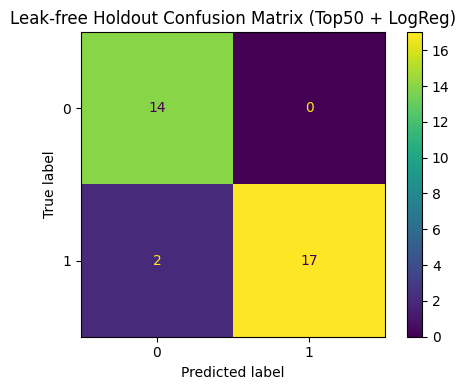

Saved figure: cm_leakfree_top50_logreg.png


In [95]:
# Leak-free HOLDOUT evaluation + Confusion Matrix 

def leakfree_holdout(X: pd.DataFrame, y: np.ndarray, top_n=50, model_name="logreg", seed=42, test_size=0.2):
    X_tr_full, X_te_full, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    feats = select_top_features_train_only(X_tr_full, y_tr, top_n=top_n)

    X_tr = X_tr_full[feats]
    X_te = X_te_full[feats]

    model = make_model(model_name=model_name, seed=seed)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    out = {
        "top_n": int(top_n),
        "model": model_name,
        "test_size": int(len(y_te)),
        "acc": float(accuracy_score(y_te, y_pred)),
        "prec": float(precision_score(y_te, y_pred, zero_division=0)),
        "rec": float(recall_score(y_te, y_pred, zero_division=0)),
        "f1": float(f1_score(y_te, y_pred, zero_division=0)),
        "selected_features": feats
    }
    return model, X_te, y_te, out

# Generate one clean holdout run (Top50 + LogReg)
best_model, X_test, y_test, holdout_res = leakfree_holdout(X_full, y, top_n=50, model_name="logreg", seed=42)

print("Leak-free HOLDOUT metrics (Top50 + LogReg):")
print({k: v for k, v in holdout_res.items() if k != "selected_features"})

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
ax.set_title("Leak-free Holdout Confusion Matrix (Top50 + LogReg)")
plt.tight_layout()
plt.savefig(FIGURES / "cm_leakfree_top50_logreg.png", dpi=200)
plt.show()

print("Saved figure:", (FIGURES / "cm_leakfree_top50_logreg.png").name)

In [97]:
# Save the final selected signature (Top50 from holdout train-only selection)

final_signature = pd.DataFrame({"feature": holdout_res["selected_features"]})
final_signature.to_csv(RESULTS / "final_signature_top50_holdout.csv", index=False)

print("Saved: results/final_signature_top50_holdout.csv")
display(final_signature.head(10))

Saved: results/final_signature_top50_holdout.csv


,feature
0,7958000
1,7961102
2,8095694
3,8151592
4,8156706
5,8138789
6,8180377
7,8063478
8,7958262
9,8005687


Leak-free HOLDOUT metrics (Top50 + RF):
{'top_n': 50, 'model': 'rf', 'test_size': 33, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}


,feature,importance
0,8013272,0.079154
1,8095694,0.057128
2,8089928,0.050988
3,8156706,0.044972
4,7961102,0.038779
5,7958000,0.038680
6,8013268,0.036781
7,8005225,0.034259
8,8005231,0.033183
9,8005687,0.032527


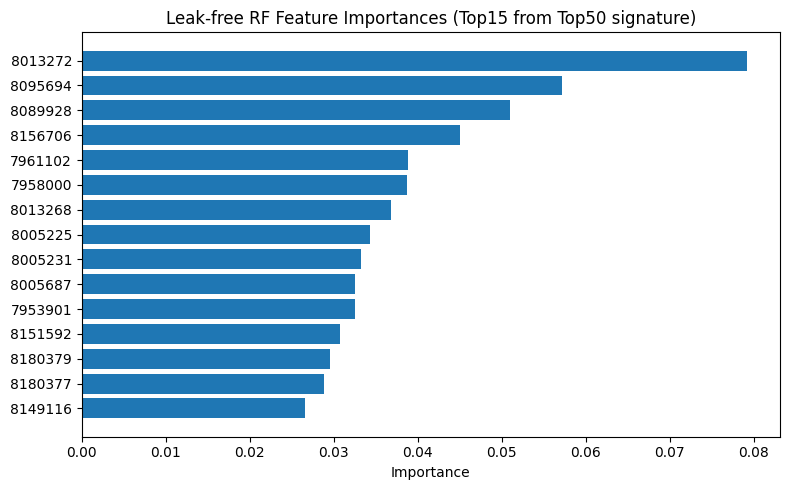

Saved: top_predictive_features_rf_leakfree.csv feature_importance_rf_leakfree_top15.png


In [101]:
#Leak-free RandomForest holdout + feature importances 

rf_model, X_test_rf, y_test_rf, holdout_rf = leakfree_holdout(X_full, y, top_n=50, model_name="rf", seed=42)

print("Leak-free HOLDOUT metrics (Top50 + RF):")
print({k: v for k, v in holdout_rf.items() if k != "selected_features"})

importances = pd.Series(rf_model.feature_importances_, index=holdout_rf["selected_features"]).sort_values(ascending=False)
top15 = importances.head(15).reset_index()
top15.columns = ["feature", "importance"]

display(top15)

top15.to_csv(RESULTS / "top_predictive_features_rf_leakfree.csv", index=False)

plt.figure(figsize=(8,5))
plt.barh(top15["feature"][::-1], top15["importance"][::-1])
plt.title("Leak-free RF Feature Importances (Top15 from Top50 signature)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(FIGURES / "feature_importance_rf_leakfree_top15.png", dpi=200)
plt.show()

print("Saved:",
      (RESULTS / "top_predictive_features_rf_leakfree.csv").name,
      (FIGURES / "feature_importance_rf_leakfree_top15.png").name)

In [103]:
# Save modeling matrices for reuse (Top20/Top50 selected on FULL DATA is NOT used for evaluation)

top20_full = select_top_features_train_only(X_full, y, top_n=20)
top50_full = select_top_features_train_only(X_full, y, top_n=50)

X_sig20 = X_full[top20_full].copy()
X_sig50 = X_full[top50_full].copy()

(X_sig20.assign(y=y)).to_csv(RESULTS / "modeling_signature20_full.csv", index=True)
(X_sig50.assign(y=y)).to_csv(RESULTS / "modeling_signature50_full.csv", index=True)

print("Saved (for downstream use only):")
print(" - results/modeling_signature20_full.csv")
print(" - results/modeling_signature50_full.csv")

Saved (for downstream use only):
 - results/modeling_signature20_full.csv
 - results/modeling_signature50_full.csv


In [107]:
# Load & test your previously saved model file 

import joblib

model_path = MODEL_DIR / "sleep_classifier.pkl"
if model_path.exists():
    saved_model = joblib.load(model_path)
    print("Loaded saved model:", type(saved_model))

    # Try with the full-data top50 matrix (same feature-space you likely used earlier)
    X_try = X_sig50
    try:
        y_pred = saved_model.predict(X_try)
        print("Saved model metrics on full-data signature50 feature space:")
        print("acc:", round(accuracy_score(y, y_pred), 3),
              "f1:", round(f1_score(y, y_pred, zero_division=0), 3))
        fig, ax = plt.subplots(figsize=(5,4))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax)
        ax.set_title("Saved Model Confusion Matrix (Full-data Top50 features)")
        plt.show()
    except Exception as e:
        print(" Saved model incompatible with current feature matrix:", e)
else:
    print(" No saved model found at:", model_path.resolve())

Loaded saved model: <class 'dict'>
 Saved model incompatible with current feature matrix: 'dict' object has no attribute 'predict'
